<a href="https://colab.research.google.com/github/emilia-uncc/IntroML/blob/main/assignment5/Assignment5_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.optim as optim
import torch.nn as nn
from torch.autograd import Variable


#mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
file_path = '/content/drive/My Drive/DataSets/Housing.csv'
housing = pd.DataFrame(pd.read_csv(file_path))
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [30]:
housing.isnull().sum()*100/housing.shape[0]

price               0.0
area                0.0
bedrooms            0.0
bathrooms           0.0
stories             0.0
mainroad            0.0
guestroom           0.0
basement            0.0
hotwaterheating     0.0
airconditioning     0.0
parking             0.0
prefarea            0.0
furnishingstatus    0.0
dtype: float64

In [31]:
varlist =  ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']

# Defining the map function
def binary_map(x):
    return x.map({'yes': 1, 'no': 0})

# Applying the function to the housing list
housing[varlist] = housing[varlist].apply(binary_map)
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished


In [32]:
selected_columns_indices = [1, 2, 3, 4, 10]
print(selected_columns_indices)
X = housing.iloc[:, selected_columns_indices].values
#M = 1, E = 0
Y = housing.iloc[:, 0].values

[1, 2, 3, 4, 10]


In [33]:
np.random.seed(0)
#df_train = training set, #df_test = testset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, random_state = 0)

In [34]:
#scale dataset, inputs and outputs
#scaler = StandardScaler()
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# Fit the scaler on the data
#scaler.fit(Y_train.reshape(-1, 1))  # Reshape the 1D array to 2D (n_samples, n_features)
# Transform the data
#Y_train = scaler.transform(Y_train.reshape(-1, 1))

#scaler.fit(Y_test.reshape(-1, 1))
#Y_test = scaler.transform(Y_test.reshape(-1, 1))

print(X_train[0], X_test[0], Y_train[0], Y_test[0])


[0.12419939 0.2        0.         0.         0.        ] [0.15065441 0.4        0.         0.33333333 0.33333333] 1750000 4585000


In [35]:
#define class with PyTorch for multidimensional model using neural network library
class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)

    def forward(self, x):
        out = self.linear(x)
        return out


In [36]:
#arrays into tensors
X_train_tensor =torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)

In [42]:
#set input and output dimensions
inputDim = 5
outputDim = 1
#set learning rate and epochs
learningRate = 0.1
epochs = 5000

#create model
model = linearRegression(inputDim, outputDim)
learning_rates =[0.1, 0.01, 0.001, 0.0001]

for learning_rate in learning_rates:
  print(learning_rate)
  criterion = torch.nn.MSELoss() #set lossfuntion from neural network library
  optimizer_adam = torch.optim.Adam(model.parameters(), lr=learningRate) #set optimizer Adam
  optimizer_sgd = torch.optim.SGD(model.parameters(), lr=learningRate) #set optimizer SGD

  test_losses = []
  train_losses = []

  for epoch in range(epochs+1):
      # Converting inputs and labels to Variable
      inputs = Variable(X_train_tensor)
      labels = Variable(Y_train_tensor)
      inputs_val = Variable(X_test_tensor)
      labels_val = Variable(Y_test_tensor)

      # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
      optimizer_adam.zero_grad()
      #optimizer_sgd.zero_grad()

      # get output from the model, given the inputs
      outputs = model(inputs)
      outputs = outputs.view(436)
      # get loss for the predicted output
      loss = criterion(outputs, labels)

      # Forward pass and loss calculation for the test set
      with torch.no_grad():
          val_pred = model(inputs_val)
          val_pred = val_pred.view(109)
          test_loss = criterion(val_pred, labels_val)

      #print(loss)
      # get gradients w.r.t to parameters
      loss.backward()

      # update parameters
      optimizer_adam.step()
      #optimizer_sgd.step()

      if epoch % 500 == 0:
              print(f"Epoch: {epoch}, Loss: {loss.item()}, val_loss: {test_loss.item()}")

      train_losses.append(loss.item())
      test_losses.append(test_loss.item())



0.1
Epoch: 0, Loss: 26469977817088.0, val_loss: 25189242896384.0
Epoch: 500, Loss: 26468797120512.0, val_loss: 25188091559936.0
Epoch: 1000, Loss: 26467618521088.0, val_loss: 25186944417792.0
Epoch: 1500, Loss: 26466437824512.0, val_loss: 25185790984192.0
Epoch: 2000, Loss: 26465261322240.0, val_loss: 25184641744896.0
Epoch: 2500, Loss: 26464078528512.0, val_loss: 25183494602752.0
Epoch: 3000, Loss: 26462902026240.0, val_loss: 25182345363456.0
Epoch: 3500, Loss: 26461721329664.0, val_loss: 25181196124160.0
Epoch: 4000, Loss: 26460544827392.0, val_loss: 25180048982016.0
Epoch: 4500, Loss: 26459362033664.0, val_loss: 25178901839872.0
Epoch: 5000, Loss: 26458185531392.0, val_loss: 25177748406272.0
0.01
Epoch: 0, Loss: 26458183434240.0, val_loss: 25177746309120.0
Epoch: 500, Loss: 26457002737664.0, val_loss: 25176599166976.0
Epoch: 1000, Loss: 26455826235392.0, val_loss: 25175447830528.0
Epoch: 1500, Loss: 26454649733120.0, val_loss: 25174300688384.0
Epoch: 2000, Loss: 26453466939392.0, va

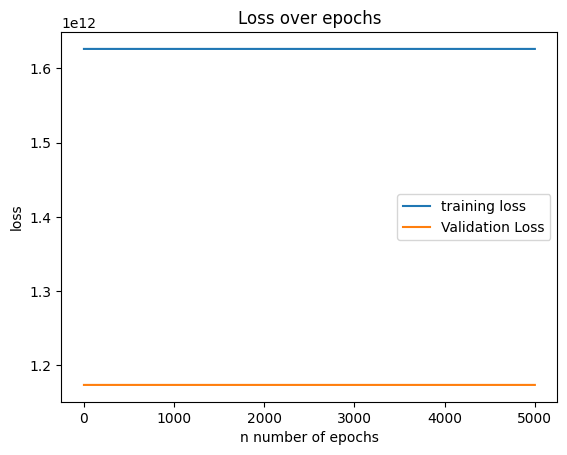

In [44]:
# 4. Plot the training and validation loss after each iteration
plt.plot(train_losses, label="training loss")
plt.plot(test_losses, label="Validation Loss")
plt.xlabel("n number of epochs")
plt.ylabel("loss")
plt.legend()
plt.title("Loss over epochs")
plt.show()

In [43]:
#set input and output dimensions
inputDim = 5
outputDim = 1
#set learning rate and epochs
learningRate = 0.1
epochs = 5000

#create model
model = linearRegression(inputDim, outputDim)
learning_rates =[0.1, 0.01, 0.001, 0.0001]

for learning_rate in learning_rates:
  print(learning_rate)

  criterion = torch.nn.MSELoss() #set lossfuntion from neural network library
  optimizer_adam = torch.optim.Adam(model.parameters(), lr=learningRate) #set optimizer Adam
  optimizer_sgd = torch.optim.SGD(model.parameters(), lr=learningRate) #set optimizer SGD

  test_losses = []
  train_losses = []

  for epoch in range(epochs+1):
      # Converting inputs and labels to Variable
      inputs = Variable(X_train_tensor)
      labels = Variable(Y_train_tensor)
      inputs_val = Variable(X_test_tensor)
      labels_val = Variable(Y_test_tensor)

      # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
      #optimizer_adam.zero_grad()
      optimizer_sgd.zero_grad()

      # get output from the model, given the inputs
      outputs = model(inputs)
      outputs = outputs.view(436)
      # get loss for the predicted output
      loss = criterion(outputs, labels)

      # Forward pass and loss calculation for the test set
      with torch.no_grad():
          val_pred = model(inputs_val)
          val_pred = val_pred.view(109)
          test_loss = criterion(val_pred, labels_val)

      #print(loss)
      # get gradients w.r.t to parameters
      loss.backward()

      # update parameters
      #optimizer_adam.step()
      optimizer_sgd.step()

      if epoch % 500 == 0:
              print(f"Epoch: {epoch}, Loss: {loss.item()}, val_loss: {test_loss.item()}")

      train_losses.append(loss.item())
      test_losses.append(test_loss.item())

0.1
Epoch: 0, Loss: 26469982011392.0, val_loss: 25189244993536.0
Epoch: 500, Loss: 1634180399104.0, val_loss: 1156270391296.0
Epoch: 1000, Loss: 1626230489088.0, val_loss: 1170313445376.0
Epoch: 1500, Loss: 1626013564928.0, val_loss: 1173285634048.0
Epoch: 2000, Loss: 1626007273472.0, val_loss: 1173729312768.0
Epoch: 2500, Loss: 1626007273472.0, val_loss: 1173784887296.0
Epoch: 3000, Loss: 1626007142400.0, val_loss: 1173790654464.0
Epoch: 3500, Loss: 1626007142400.0, val_loss: 1173788688384.0
Epoch: 4000, Loss: 1626007142400.0, val_loss: 1173788688384.0
Epoch: 4500, Loss: 1626007142400.0, val_loss: 1173788688384.0
Epoch: 5000, Loss: 1626007142400.0, val_loss: 1173788688384.0
0.01
Epoch: 0, Loss: 1626007142400.0, val_loss: 1173788688384.0
Epoch: 500, Loss: 1626007142400.0, val_loss: 1173788688384.0
Epoch: 1000, Loss: 1626007142400.0, val_loss: 1173788688384.0
Epoch: 1500, Loss: 1626007142400.0, val_loss: 1173788688384.0
Epoch: 2000, Loss: 1626007142400.0, val_loss: 1173788688384.0
Epoch

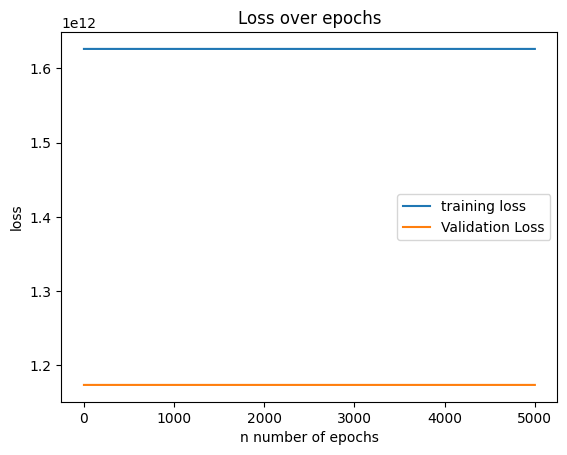

In [45]:
# 4. Plot the training and validation loss after each iteration
plt.plot(train_losses, label="training loss")
plt.plot(test_losses, label="Validation Loss")
plt.xlabel("n number of epochs")
plt.ylabel("loss")
plt.legend()
plt.title("Loss over epochs")
plt.show()